In [338]:
# arima forecast for the power usage dataset
import pandas as pd
import numpy as np

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
# from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import psutil
import ast

## Loading in and structuring data

In [339]:
# load in data and visualise
dataset = pd.read_csv('wb_47_for_arima.csv', parse_dates=True, index_col = 'time', header=0)
# Limit datast so it only includes complete 24 hour periods
dataset = dataset.iloc[9:489, 1]


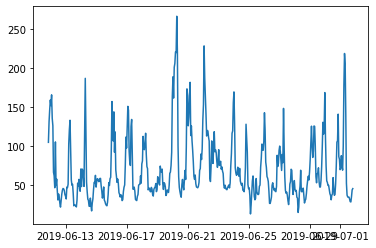

In [340]:
# simple plot of the dataset over three weeks
plt.plot(dataset)

In [341]:
# limit dataset to values only and save as an array
dataset = dataset.values

In [342]:
dataset

array([105.1072093 , 131.27704545, 146.71704545, 159.31302326,
       152.17409091, 165.95909091, 135.90116279, 126.35      ,
        66.82093023,  62.26395349,  46.91931818, 105.61883721,
        50.69090909,  58.02906977,  42.74431818,  31.20681818,
        38.89545455,  34.92422222,  26.96727273,  22.09866667,
        29.856     ,  38.5272093 ,  43.67568182,  45.99116279,
        45.41340909,  43.36840909,  38.09772727,  35.96840909,
        32.53466667,  47.69534884,  47.06418605,  51.46590909,
       103.1472093 , 121.66363636, 133.40045455,  93.74232558,
        56.98697674,  50.21704545,  51.32772727,  39.87681818,
        23.77288889,  25.02977778,  24.70911111,  23.71311111,
        22.35688889,  31.13704545,  52.69674419,  48.80233333,
        57.61666667,  45.18257143,  42.40372093,  70.92772727,
        48.41395349,  70.87488372,  69.50488372,  58.72727273,
        48.65232558, 120.79906977, 187.1247619 , 125.72069767,
        54.24880952,  41.9275    ,  32.28681818,  30.61

It appears that autocorrelation values of 6 or 7 are reasonable although around 10-15 and 23 plus are also potentially valid

In [343]:
dataset.shape

(480,)

Create a list of models to be tested
Split the datset into train and test leaving 24 hours out of sample
split the train and test set into 19 lists represetning days each containing a list of 24 hours,

Evaluate the models on the train and test set





Generate 
    score - 
    scores - 


Split the datset into train and test leaving 24 hours out of sample
split the train and test set into 19 lists represetning days each containing a list of 24 hours,

In [350]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[0:-192], data[-192:-24]
    final_test = data[-24:]
    # restructure into windows of weekly data
    train = array(split(train, (len(train)/24)))
    test = array(split(test, (len(test)/24)))
    return train, test, final_test

In [351]:
# Generating train and test
train, test = split_dataset(dataset)[0:2]

In [354]:
final_test = split_dataset(dataset)[2]
print('final test', final_test)
print('final test shape',final_test.shape)

final test [141.21431818  86.77255814  83.38372093  70.07931818  71.70674419
  88.01860465  75.67651163  69.44       100.31931818 177.3644186
 218.97888889 205.83318182 140.97        52.6         37.45
  35.20111111  34.62477273  34.9375      32.36644444  28.9675
  28.75266667  35.57818182  44.09181818  45.78977273]
final test shape (24,)


In [347]:
#Checking the size of the train and test sets
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (12, 24)
test shape:  (7, 24)


Create a list of models to be tested

In [265]:
train.shape

(12, 24)

Evauate the actual and predicted ie the test set and the predicted set
For each of the 24 column in the train set
calculate the rmse for the actual and predicted, this will be hour by hour
add the score to the scores list which is a list of rmses for each hour

for each day
For each row, for each column calculate the rmse of the pairs
square and add the total to the list
Once complete calculate score by dividing s by the size of the test set




In [266]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
    # extract just the total power from each week
    series = [day for day in data]
    # flatten into a single series
    series = array(series).flatten()
    print('series.shape: ', series.shape)
    return series

In [267]:
# sarima forecast
# Takes the history (train set plus day by day testing) and configuration
# converts history values to a single long series
# generates the sarima model based on config parameters
# fits the sarima model to the series data
# creates yhat, a prediction of the next 24 hours int he test set
# def sarima_forecast(history, config):
#     order, sorder, trend = config
#     print('order', order)
#     print('sorder', sorder)
#     print('trand', trend)
#     # convert history into a univariate series
#     series = to_series(history)
# #     series = to_series(history)
# #     print('series', series)
#     # define model
#     model = SARIMAX(series, order=order, seasonal_order=sorder, trend = trend,enforce_stationarity=False, enforce_invertibility=False)
# #     model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
#     print('model', model)
#     # fit model
#     model_fit = model.fit(disp=False)
#     # make one step forecast
#     yhat = model_fit.predict(len(series), len(series)+24)
# #     print('yhat', yhat)
# #     print('yhat 0', yhat[0])
#     return yhat

In [364]:
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    print('t',t)
    print('d',d)
    print('s',s)
    print('p',p)
    print('b',b)
    print('r',r)
    # define model
#     history = array(history)
    series = to_series(history)
#     print('history', history)
    model = ExponentialSmoothing(series, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    print('model', model)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(series), len(series)+23)
    print('yhat', yhat)
    return yhat

In [269]:
# evaluate a single model which creates a prediction for ech day and each hour
# This is then fed into the evaluate forecast function to generate overall scores for the model
# for the model
# This needs to happen for every incarnation of the model
def evaluate_model(model_func, train, test, config):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
##        config = ((2,0,6), (1,0,1,24), 'n')
        yhat_sequence = model_func(history, config)
#         yhat_sequence = sarima_fore(history, config)
#         print('history', history)
#         print('yhat_sequence', yhat_sequence)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        print('test[i,:]',test[i,:])
        history.append(test[i, :])
#         print('predictions', predictions)
#         print('history', history)
    predictions = array(predictions)
#     print('len(predictions)', len(predictions))
    print('predictions.shape', predictions.shape)
    # evaluate predictions days for each week
#     score, scores = evaluate_forecasts(test, predictions)
    score, scores = evaluate_forecasts(test, predictions)
    print('score', score)
#     print('scores', scores)
#     return score, scores
    return score, scores

In [270]:
# evaluate forecasts for all hours across all days
# takes all the actual and predicted values gained through the test set
# For each of the 24 columns, take the rmse of the column in actual and predicted
# add the rmse for each hour in each day to 'SCORES' a list of 24 rmse

# Then compare the differnce betwen individual for each row (day) and each column (hour) in the actual and predicted. 
# Square them, sum them and divide by the number of cells to give and average rmse
# This is SCORE
# Return SCORE and scores

def evaluate_forecasts(actual, predicted):
    print('actual.shape : ', actual.shape)
#     print('predicted.shape', predicted.shape)
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        print('i', i)
#         print('actual.shape : ', actual.shape)
#         print('predicted.shape', predicted.shape)
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        print('mse', mse)
        # calculate rmse
        rmse = sqrt(mse)
        print('rmse', rmse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
#     return score, scores
    return score, scores

In [271]:
# summarize scores
#Takes the name, model score and list of hourley mean scores
#print
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f]' % (name, score))

In [294]:
# create a set of exponential smoothing configs to try
def exp_smoothing_configs():
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = [24]
    b_params = [True,False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

In [295]:
# grid search configs
# Using train, test data and the list of configurations
# working in parallel


# def grid_search(data, cfg_list, n_test, parallel=True):
def grid_search(exp_smoothing_forecast, train, test, cfg_list, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=psutil.cpu_count(), verbose=1)
        tasks = (delayed(score_model)(exp_smoothing_forecast,train, test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(exp_smoothing_forecast,train, test, cfg) for cfg in cfg_list]
    # remove empty results
    print(scores)
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [296]:
# score a model, return None on failure

def score_model(exp_smoothing_forecast,train, test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
#         result = walk_forward_validation(data, n_test, cfg)
        result = evaluate_model(exp_smoothing_forecast,train, test, cfg)[0]
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = evaluate_model(exp_smoothing_forecast,train, test, cfg)[0]
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

The summary of the scores takes the name of the mode, the overall score in square brackets and a list of each of the 24 hourly socres

For each model using the train and test set
take each of the 12 X 24 hours lists and read them into 'history'
generate an empty list (predictions)
apply the model to history to generate a sequence of predictions called yhat - this will be.....
add that sequence to the predictions list
add the firsts and subsequent days data to the list of histories
Once all forecasts have been made and history comprises the whole training and test set
Evaluate the result based on the test set and the predictions made
return score and scores

take a list of data known as history, in this case it is a list of lists for each day

Define models to be trained

In [297]:
# define the names and functions for the models we wish to evaluate
models = dict()
models['exp_smoothing_forecast'] = exp_smoothing_forecast

# name each hour to be aggregated
hours = ['0', '1', '2', '3', '4', '5', '6', '7', '8','9','10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

In [298]:
# data split
n_test = 24
# model configs
cfg_list = exp_smoothing_configs()
# print(cfg_list)

In [310]:
# grid search
scores = grid_search(exp_smoothing_forecast, train, test, cfg_list)
print('done')
# list top 3 configs
for cfg, error in scores[:10]:
    print(cfg, error)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min


[("['add', True, 'add', 24, True, True]", 178.4189580817527), ("['add', True, 'add', 24, True, False]", 179.0901643311282), ("['add', True, 'add', 24, False, True]", 67.96324022225572), ("['add', True, 'add', 24, False, False]", 67.88182278548082), ("['add', True, 'mul', 24, True, True]", 128.75448542642906), ("['add', True, 'mul', 24, True, False]", 128.93554447772274), ("['add', True, 'mul', 24, False, True]", None), ("['add', True, 'mul', 24, False, False]", None), ("['add', True, None, 24, True, True]", 49.608185287770524), ("['add', True, None, 24, True, False]", 49.73214694138549), ("['add', True, None, 24, False, True]", 48.967585023785546), ("['add', True, None, 24, False, False]", 48.93926950875909), ("['add', False, 'add', 24, True, True]", 409.49136228753565), ("['add', False, 'add', 24, True, False]", 410.33489865406926), ("['add', False, 'add', 24, False, True]", 86.41471420383208), ("['add', False, 'add', 24, False, False]", 86.30330888535019), ("['add', False, 'mul', 24,

[Parallel(n_jobs=8)]: Done  72 out of  72 | elapsed:  1.2min finished


## PREDICTING THE NEXT 24 HOURS OUT OF SAMPLE

In [371]:
# best_config = scores[:1]
best_config = ast.literal_eval(scores[:1][0][0])

In [372]:
best_config

['mul', False, None, 24, False, True]

In [373]:
best_oos_yhat = exp_smoothing_forecast(dataset, best_config)

t mul
d False
s None
p 24
b False
r True
series.shape:  (480,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB716C9E48>
yhat [46.5675827  44.95025412 43.39222501 41.89132113 40.44544799 39.05258789
 37.71079709 36.41820314 35.17300223 33.97345669 32.81789257 31.70469728
 30.63231737 29.59925634 28.60407256 27.64537725 26.72183258 25.83214972
 24.97508715 24.14944883 23.3540826  22.58787852 21.84976736 21.1387191 ]


In [366]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [374]:
oos_rmse = measure_rmse(final_test, best_oos_yhat)
oos_rmse

71.63323432868685

array([141.21431818,  86.77255814,  83.38372093,  70.07931818,
        71.70674419,  88.01860465,  75.67651163,  69.44      ,
       100.31931818, 177.3644186 , 218.97888889, 205.83318182,
       140.97      ,  52.6       ,  37.45      ,  35.20111111,
        34.62477273,  34.9375    ,  32.36644444,  28.9675    ,
        28.75266667,  35.57818182,  44.09181818,  45.78977273])

array([46.5675827 , 44.95025412, 43.39222501, 41.89132113, 40.44544799,
       39.05258789, 37.71079709, 36.41820314, 35.17300223, 33.97345669,
       32.81789257, 31.70469728, 30.63231737, 29.59925634, 28.60407256,
       27.64537725, 26.72183258, 25.83214972, 24.97508715, 24.14944883,
       23.3540826 , 22.58787852, 21.84976736, 21.1387191 ])

In [302]:
# For each model named (only SARIMA here)
# Extract the name and the function - for a single config
# Run the model across the whole test set
# generte the score and scores
# plot the hourly scores
for name, func in models.items():
    # evaluate and get scores
    for config in cfg_list:
        score, scores = evaluate_model(func, train, test, config)
    # summarize scores
        summarize_scores(name, score, scores)

#     # plot scores
#     plt.plot(hours, scores, marker='o', label=name)
# # show plot
# plt.legend()
# plt.show()

t add
d True
s add
p 24
b True
r True
series.shape:  (288,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB71784358>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 86.67292962 107.49003954 148.88779706 226.93504128 298.58078811
 336.59403878 398.61195457 417.50258518 339.83178699 335.00367025
 307.90832909 260.49917197 161.83439405 108.98048684  79.71967481
  71.28038762  70.75405088  66.58517777  60.62723052  57.54276333
  56.24060644  51.73174292  56.5106677   71.76714151  86.68844367]
test[i,:] [ 90.41953488 116.68       119.81818182 156.10954545 169.71744186
 128.95        72.78162791  65.81976744  62.78184211  64.4272093
  73.24585366  64.75372093  61.61275     71.68804878  55.6604878
  52.19384615  50.14390244  52.62547619  43.81875     43.17926829
  41.83590909  50.96075     72.6225641  128.30348837]
t add
d True
s add
p 24
b True
r True
series.shape:  (312,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB71784438>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [144.76242209 191.67198085 256.02603652 434.74872055 598.85235547
 633.09681907 611.38932853 735.88287962 633.7069429  591.75692104
 533.90299181 379.87296896 239.01584455 166.74022312 109.7888758
 101.84431208 100.01188651  95.66776985  82.36812783  80.66758551
  76.78451492  76.581751    89.8413598  118.28779753 144.84339755]
test[i,:] [110.09428571  92.6275      51.03756098  45.68340909  46.64727273
  36.73372093  13.36888889  24.74136364  39.64318182  55.67023256
  62.03292683  47.76238095  35.64977778  31.47809524  33.15068182
  58.70351351  41.93454545  39.19136364  38.10666667  38.86595238
  48.742       50.36833333  73.45697674  84.56829268]
t add
d True
s add
p 24
b True
r True
series.shape:  (336,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70FAED30>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 89.22015148 107.70116627 119.00379779 197.25177282 288.68072519
 293.11811636 195.56952203 461.3685634  452.64684032 387.86115427
 314.30000692 209.89620328 140.73302487 107.18867582  80.66197472
  84.25303789  64.22836418  63.95911643  58.31679612  56.89169379
  58.14266695  54.88855104  66.11406464  85.71817559  89.15568751]
test[i,:] [102.88681818  96.04674419  94.93261905 106.34404762 143.03909091
 120.78840909  79.88372093  73.12697674  61.21209302  59.16295455
  54.8955814   42.68340909  26.91952381  26.79883721  30.38404762
  35.01181818  50.          53.25972973  48.05804878  43.86113636
  45.87119048  42.24948718  41.91642857  48.70545455]
t add
d True
s add
p 24
b True
r True
series.shape:  (360,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB71784668>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 53.99496374  61.54384853  72.26026099 109.28542243 157.48427005
 152.36323972 111.46692868 173.35021577 169.34295487 151.45831814
 123.05578719  86.23296595  58.58034811  51.64409587  44.89000204
  46.37600849  41.58825605  36.90915361  32.76924789  31.49383382
  31.74775594  29.80215745  35.28314867  47.7945097   53.92497118]
test[i,:] [ 88.4995122   74.25818182  78.34486486  94.69511628 100.30431818
  93.22604651  81.19        69.05953488  89.48511628  78.92227273
 148.60136364  98.77790698  60.50595238  43.46238095  39.85682927
  41.26710526  37.19761905  30.2002381   25.33478261  34.684
  51.63488372  54.79487179  70.611       69.30756098]
t add
d True
s add
p 24
b True
r True
series.shape:  (384,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70F92470>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 92.61823279  90.96648867 110.73964298 171.14245879 251.32597498
 257.00349999 192.72511304 261.39870645 312.80653232 260.26094083
 254.63815686 141.6267974   89.00211401  75.07276895  68.09349416
  70.43710786  62.5031154   53.71303875  47.44258323  50.47042364
  51.83282969  45.62409895  53.59833382  70.76230573  92.39115342]
test[i,:] [49.01488372 38.27714286 47.759      56.10418605 44.83153846 42.39181818
 43.5275     34.77       33.55818182 15.25266667 22.22166667 41.61857143
 48.93926829 69.3404878  42.29918919 41.63363636 45.5925641  46.35619048
 36.56153846 27.39116279 30.5847619  32.25162791 39.34674419 49.26657895]
t add
d True
s add
p 24
b True
r True
series.shape:  (408,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB71784278>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 56.97227501  60.2063938   79.03084683 113.1810496  146.69037751
 166.50884241 139.49042997 153.90890801 191.705989   132.75661823
 183.39109891 128.18975738  71.32850666  59.0670737   44.55671032
  48.88988961  46.84428097  40.49362462  33.8411261   33.84256856
  38.02797044  34.47587711  39.20371224  47.4459164   57.02954857]
test[i,:] [ 56.49627907  61.68439024  56.85931818  67.63358974  83.34348837
 103.03418605 125.815      100.56209302  85.73454545  93.97883721
 126.08324324 125.57902439  99.78675     61.08325581  53.25023256
  64.94756098  65.5985      72.4485      54.47368421  47.82642857
  47.83209302  56.07906977  73.69136364  99.43090909]
t add
d True
s add
p 24
b True
r True
series.shape:  (432,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70FAEDA0>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [117.69577337 127.47381026 158.42443924 250.4192222  356.47051433
 431.26559283 377.33235025 354.23353161 439.06667193 355.41957262
 472.55864855 330.29917961 168.16019427 116.13815474  91.61874959
 102.04990714  95.99222428  85.13869888  64.82155838  63.7181141
  72.72423609  71.22953578  80.85865469  97.49110297 118.00461937]
test[i,:] [130.82023256 115.52590909 125.12113636 168.86767442 112.25613636
  74.86395349  55.70395349  53.74204545  49.86116279  49.99465116
  44.92681818  39.25697674  37.09422222  31.47045455  37.34613636
  39.00363636  59.87372093  46.60139535  37.20522727  38.44755556
  51.9544186   74.03931818 105.34488372 107.12348837]
predictions.shape (7, 25)
actual.shape :  (7, 24)
i 0
mse 666.7126320550185
rmse 25.82077907529164
i 1
mse 1873.264051780655
rmse 43.281220544026425
i 2
mse 7007.001391902496
rmse 83.7078335157618
i 3
mse 26689.169887733828
rmse 163.36820341710876
i 4
mse 64615.81300360162
rmse 254.1964063546171
i 5
mse 87009.86596898896
rmse 294.97434

C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 87.5560014  108.37311132 149.77086883 227.81811305 299.46385989
 337.47711055 399.49502635 418.38565696 340.71485877 335.88674203
 308.79140086 261.38224375 162.71746582 109.86355862  80.60274658
  72.16345939  71.63712265  67.46824954  61.51030229  58.42583511
  57.12367821  52.61481469  57.39373948  72.65021328  87.57151544]
test[i,:] [ 90.41953488 116.68       119.81818182 156.10954545 169.71744186
 128.95        72.78162791  65.81976744  62.78184211  64.4272093
  73.24585366  64.75372093  61.61275     71.68804878  55.6604878
  52.19384615  50.14390244  52.62547619  43.81875     43.17926829
  41.83590909  50.96075     72.6225641  128.30348837]
t add
d True
s add
p 24
b True
r False
series.shape:  (312,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70FAE400>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [145.76176126 192.67132002 257.02537569 435.74805972 599.85169464
 634.09615824 612.3886677  736.88221879 634.70628207 592.75626021
 534.90233098 380.87230813 240.01518372 167.73956229 110.78821497
 102.84365125 101.01122568  96.66710902  83.367467    81.66692468
  77.78385409  77.58109017  90.84069897 119.2871367  145.84273672]
test[i,:] [110.09428571  92.6275      51.03756098  45.68340909  46.64727273
  36.73372093  13.36888889  24.74136364  39.64318182  55.67023256
  62.03292683  47.76238095  35.64977778  31.47809524  33.15068182
  58.70351351  41.93454545  39.19136364  38.10666667  38.86595238
  48.742       50.36833333  73.45697674  84.56829268]
t add
d True
s add
p 24
b True
r False
series.shape:  (336,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E417F0>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 90.55597386 109.03698865 120.33962017 198.5875952  290.01654757
 294.45393874 196.9053444  462.70438577 453.9826627  389.19697664
 315.63582929 211.23202565 142.06884724 108.5244982   81.9977971
  85.58886026  65.56418656  65.2949388   59.6526185   58.22751616
  59.47848933  56.22437342  67.44988701  87.05399796  90.49150989]
test[i,:] [102.88681818  96.04674419  94.93261905 106.34404762 143.03909091
 120.78840909  79.88372093  73.12697674  61.21209302  59.16295455
  54.8955814   42.68340909  26.91952381  26.79883721  30.38404762
  35.01181818  50.          53.25972973  48.05804878  43.86113636
  45.87119048  42.24948718  41.91642857  48.70545455]
t add
d True
s add
p 24
b True
r False
series.shape:  (360,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB717841D0>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 55.71397257  63.26285736  73.97926981 111.00443126 159.20327888
 154.08224855 113.18593751 175.0692246  171.0619637  153.17732697
 124.77479602  87.95197478  60.29935694  53.3631047   46.60901087
  48.09501732  43.30726488  38.62816244  34.48825672  33.21284265
  33.46676477  31.52116628  37.0021575   49.51351853  55.64398001]
test[i,:] [ 88.4995122   74.25818182  78.34486486  94.69511628 100.30431818
  93.22604651  81.19        69.05953488  89.48511628  78.92227273
 148.60136364  98.77790698  60.50595238  43.46238095  39.85682927
  41.26710526  37.19761905  30.2002381   25.33478261  34.684
  51.63488372  54.79487179  70.611       69.30756098]
t add
d True
s add
p 24
b True
r False
series.shape:  (384,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E41E48>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 94.19568008  92.54393597 112.31709027 172.71990609 252.90342228
 258.58094729 194.30256033 262.97615374 314.38397961 261.83838813
 256.21560416 143.20424469  90.57956131  76.65021625  69.67094146
  72.01455515  64.08056269  55.29048605  49.02003052  52.04787093
  53.41027699  47.20154625  55.17578112  72.33975302  93.96860072]
test[i,:] [49.01488372 38.27714286 47.759      56.10418605 44.83153846 42.39181818
 43.5275     34.77       33.55818182 15.25266667 22.22166667 41.61857143
 48.93926829 69.3404878  42.29918919 41.63363636 45.5925641  46.35619048
 36.56153846 27.39116279 30.5847619  32.25162791 39.34674419 49.26657895]
t add
d True
s add
p 24
b True
r False
series.shape:  (408,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70F92470>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 58.74773321  61.98185199  80.80630503 114.9565078  148.46583571
 168.28430061 141.26588817 155.68436621 193.4814472  134.53207643
 185.16655711 129.96521558  73.10396485  60.84253189  46.33216851
  50.66534781  48.61973917  42.26908282  35.6165843   35.61802676
  39.80342863  36.25133531  40.97917044  49.22137459  58.80500677]
test[i,:] [ 56.49627907  61.68439024  56.85931818  67.63358974  83.34348837
 103.03418605 125.815      100.56209302  85.73454545  93.97883721
 126.08324324 125.57902439  99.78675     61.08325581  53.25023256
  64.94756098  65.5985      72.4485      54.47368421  47.82642857
  47.83209302  56.07906977  73.69136364  99.43090909]
t add
d True
s add
p 24
b True
r False
series.shape:  (432,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB7169C160>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [119.11768769 128.89572458 159.84635356 251.84113652 357.89242866
 432.68750716 378.75426458 355.65544593 440.48858625 356.84148694
 473.98056287 331.72109394 169.5821086  117.56006907  93.04066391
 103.47182146  97.4141386   86.56061321  66.2434727   65.14002842
  74.14615042  72.65145011  82.28056902  98.9130173  119.42653369]
test[i,:] [130.82023256 115.52590909 125.12113636 168.86767442 112.25613636
  74.86395349  55.70395349  53.74204545  49.86116279  49.99465116
  44.92681818  39.25697674  37.09422222  31.47045455  37.34613636
  39.00363636  59.87372093  46.60139535  37.20522727  38.44755556
  51.9544186   74.03931818 105.34488372 107.12348837]
predictions.shape (7, 25)
actual.shape :  (7, 24)
i 0
mse 670.090418321889
rmse 25.886104734430187
i 1
mse 1927.30560264384
rmse 43.90108885487739
i 2
mse 7134.251900951694
rmse 84.46450083290432
i 3
mse 26970.099472730442
rmse 164.22575764090857
i 4
mse 65116.1061137163
rmse 255.17857690981094
i 5
mse 87603.09191525313
rmse 295.97819

C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 81.86654753  98.72880297 132.23439437 164.99919715 180.67663673
 193.97839434 189.98397972 180.66962739 152.91040146 141.11628135
 131.78347522 110.43934764  73.3123476   55.42896977  50.81237698
  59.57296738  63.6559701   63.65173219  57.63489003  56.59991984
  57.81267756  57.11857707  61.15419832  74.55176607  82.03168801]
test[i,:] [ 90.41953488 116.68       119.81818182 156.10954545 169.71744186
 128.95        72.78162791  65.81976744  62.78184211  64.4272093
  73.24585366  64.75372093  61.61275     71.68804878  55.6604878
  52.19384615  50.14390244  52.62547619  43.81875     43.17926829
  41.83590909  50.96075     72.6225641  128.30348837]
t add
d True
s add
p 24
b False
r True
series.shape:  (312,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB711E5278>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [135.87064693 160.22987651 190.81327636 226.97103268 238.14895761
 238.45871686 229.58591544 224.96956699 198.06216894 181.47000786
 169.19683068 148.68952137 122.1542858  112.12153919 106.97786497
 113.7602843  113.7988799  112.67927027 106.95896865 106.1356733
 105.41990374 107.86255786 116.33431198 127.82785083 136.81362298]
test[i,:] [110.09428571  92.6275      51.03756098  45.68340909  46.64727273
  36.73372093  13.36888889  24.74136364  39.64318182  55.67023256
  62.03292683  47.76238095  35.64977778  31.47809524  33.15068182
  58.70351351  41.93454545  39.19136364  38.10666667  38.86595238
  48.742       50.36833333  73.45697674  84.56829268]
t add
d True
s add
p 24
b False
r True
series.shape:  (336,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70F92470>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 83.12577294 104.32745515 131.00153597 172.7608161  188.80217062
 188.33455563 178.14446044 177.82928763 154.34207878 135.49634309
 120.36357662  97.46710466  72.6755694   62.41363711  58.51200502
  68.03313214  62.27696716  62.74478002  57.80592621  56.58817462
  57.22792353  57.7404133   68.69136837  84.99036437  82.95451798]
test[i,:] [102.88681818  96.04674419  94.93261905 106.34404762 143.03909091
 120.78840909  79.88372093  73.12697674  61.21209302  59.16295455
  54.8955814   42.68340909  26.91952381  26.79883721  30.38404762
  35.01181818  50.          53.25972973  48.05804878  43.86113636
  45.87119048  42.24948718  41.91642857  48.70545455]
t add
d True
s add
p 24
b False
r True
series.shape:  (360,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB71784358>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 50.62526118  64.08727204  90.59459128 132.15551772 156.29554158
 149.21299586 137.30451371 140.96214325 120.44004545 102.33807377
  86.15955768  63.17777444  38.14675031  28.06607468  23.75598856
  31.31505348  29.60211145  27.33431216  21.77603662  20.18613471
  21.54197664  21.21004131  31.00621139  47.9355155   50.19192449]
test[i,:] [ 88.4995122   74.25818182  78.34486486  94.69511628 100.30431818
  93.22604651  81.19        69.05953488  89.48511628  78.92227273
 148.60136364  98.77790698  60.50595238  43.46238095  39.85682927
  41.26710526  37.19761905  30.2002381   25.33478261  34.684
  51.63488372  54.79487179  70.611       69.30756098]
t add
d True
s add
p 24
b False
r True
series.shape:  (384,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E417F0>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 79.25275111  82.26691747 109.3005609  150.70329822 175.93763415
 171.80448294 159.86893476 160.95425049 149.34823581 126.12454674
 122.00394776  81.43663704  58.04503376  49.44732824  46.40966537
  52.86128194  51.68995696  49.07690578  44.36002276  44.40356084
  46.48391518  44.19065754  54.33444627  69.0837195   78.63066355]
test[i,:] [49.01488372 38.27714286 47.759      56.10418605 44.83153846 42.39181818
 43.5275     34.77       33.55818182 15.25266667 22.22166667 41.61857143
 48.93926829 69.3404878  42.29918919 41.63363636 45.5925641  46.35619048
 36.56153846 27.39116279 30.5847619  32.25162791 39.34674419 49.26657895]
t add
d True
s add
p 24
b False
r True
series.shape:  (408,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB7167A3C8>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 56.68539222  62.66179904  89.35268051 128.27261255 152.94775134
 154.92146674 144.86948681 142.16835545 133.62702065 109.66342199
 106.4352792   73.60002652  45.62970425  36.4734811   25.1537614
  34.23725396  35.29043145  32.39334839  26.26365928  25.63501202
  29.38312827  27.58389047  36.57920968  49.10009191  56.57667076]
test[i,:] [ 56.49627907  61.68439024  56.85931818  67.63358974  83.34348837
 103.03418605 125.815      100.56209302  85.73454545  93.97883721
 126.08324324 125.57902439  99.78675     61.08325581  53.25023256
  64.94756098  65.5985      72.4485      54.47368421  47.82642857
  47.83209302  56.07906977  73.69136364  99.43090909]
t add
d True
s add
p 24
b False
r True
series.shape:  (432,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70FAE898>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [107.5666626  114.02733667 135.98824096 175.42732307 203.29372782
 209.52569296 201.80066733 190.22052767 184.06549449 166.45728313
 163.75624665 130.24744828  97.45078723  83.25242115  77.25872914
  86.44100806  86.89158244  85.56195009  76.04909484  76.26472017
  80.47601399  80.85170311  89.62419507 100.38365518 108.18937474]
test[i,:] [130.82023256 115.52590909 125.12113636 168.86767442 112.25613636
  74.86395349  55.70395349  53.74204545  49.86116279  49.99465116
  44.92681818  39.25697674  37.09422222  31.47045455  37.34613636
  39.00363636  59.87372093  46.60139535  37.20522727  38.44755556
  51.9544186   74.03931818 105.34488372 107.12348837]
predictions.shape (7, 25)
actual.shape :  (7, 24)
i 0
mse 573.9464417903553
rmse 23.957179337108016
i 1
mse 1000.3779545155887
rmse 31.62875202273382
i 2
mse 3729.101683626174
rmse 61.06637113523428
i 3
mse 7346.829898031008
rmse 85.71365059330402
i 4
mse 10334.811519949968
rmse 101.66027503381036
i 5
mse 12884.628319958018
rmse 113.5

C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 81.76816478  98.63042022 132.13601162 164.90081439 180.57825397
 193.88001159 189.88559697 180.57124463 152.81201871 141.01789859
 131.68509246 110.34096488  73.21396485  55.33058701  50.71399423
  59.47458462  63.55758735  63.55334943  57.53650728  56.50153709
  57.7142948   57.02019431  61.05581556  74.45338332  81.93330525]
test[i,:] [ 90.41953488 116.68       119.81818182 156.10954545 169.71744186
 128.95        72.78162791  65.81976744  62.78184211  64.4272093
  73.24585366  64.75372093  61.61275     71.68804878  55.6604878
  52.19384615  50.14390244  52.62547619  43.81875     43.17926829
  41.83590909  50.96075     72.6225641  128.30348837]
t add
d True
s add
p 24
b False
r False
series.shape:  (312,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB7167A3C8>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [135.62191611 159.98114569 190.56454554 226.72230186 237.9002268
 238.20998605 229.33718463 224.72083617 197.81343812 181.22127705
 168.94809987 148.44079055 121.90555498 111.87280837 106.72913415
 113.51155348 113.55014908 112.43053945 106.71023783 105.88694248
 105.17117292 107.61382704 116.08558116 127.57912001 136.56489216]
test[i,:] [110.09428571  92.6275      51.03756098  45.68340909  46.64727273
  36.73372093  13.36888889  24.74136364  39.64318182  55.67023256
  62.03292683  47.76238095  35.64977778  31.47809524  33.15068182
  58.70351351  41.93454545  39.19136364  38.10666667  38.86595238
  48.742       50.36833333  73.45697674  84.56829268]
t add
d True
s add
p 24
b False
r False
series.shape:  (336,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E41E48>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 83.05043511 104.25211732 130.92619814 172.68547827 188.7268328
 188.2592178  178.06912262 177.7539498  154.26674096 135.42100526
 120.28823879  97.39176683  72.60023158  62.33829928  58.4366672
  67.95779432  62.20162934  62.66944219  57.73058838  56.51283679
  57.1525857   57.66507548  68.61603055  84.91502654  82.87918015]
test[i,:] [102.88681818  96.04674419  94.93261905 106.34404762 143.03909091
 120.78840909  79.88372093  73.12697674  61.21209302  59.16295455
  54.8955814   42.68340909  26.91952381  26.79883721  30.38404762
  35.01181818  50.          53.25972973  48.05804878  43.86113636
  45.87119048  42.24948718  41.91642857  48.70545455]
t add
d True
s add
p 24
b False
r False
series.shape:  (360,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB7119BCC0>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 50.65136236  64.11337321  90.62069245 132.18161889 156.32164275
 149.23909703 137.33061488 140.98824442 120.46614662 102.36417494
  86.18565885  63.20387561  38.17285148  28.09217585  23.78208973
  31.34115466  29.62821262  27.36041333  21.80213779  20.21223588
  21.56807781  21.23614248  31.03231256  47.96161667  50.21802567]
test[i,:] [ 88.4995122   74.25818182  78.34486486  94.69511628 100.30431818
  93.22604651  81.19        69.05953488  89.48511628  78.92227273
 148.60136364  98.77790698  60.50595238  43.46238095  39.85682927
  41.26710526  37.19761905  30.2002381   25.33478261  34.684
  51.63488372  54.79487179  70.611       69.30756098]
t add
d True
s add
p 24
b False
r False
series.shape:  (384,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70F92470>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 79.22064171  82.23480807 109.2684515  150.67118882 175.90552475
 171.77237354 159.83682536 160.92214109 149.31612641 126.09243734
 121.97183836  81.40452764  58.01292436  49.41521884  46.37755597
  52.82917254  51.65784756  49.04479637  44.32791336  44.37145144
  46.45180578  44.15854814  54.30233687  69.0516101   78.59855415]
test[i,:] [49.01488372 38.27714286 47.759      56.10418605 44.83153846 42.39181818
 43.5275     34.77       33.55818182 15.25266667 22.22166667 41.61857143
 48.93926829 69.3404878  42.29918919 41.63363636 45.5925641  46.35619048
 36.56153846 27.39116279 30.5847619  32.25162791 39.34674419 49.26657895]
t add
d True
s add
p 24
b False
r False
series.shape:  (408,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E41E48>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 56.69615192  62.67255875  89.36344021 128.28337226 152.95851105
 154.93222645 144.88024652 142.17911516 133.63778035 109.6741817
 106.4460389   73.61078623  45.64046396  36.4842408   25.1645211
  34.24801367  35.30119116  32.40410809  26.27441899  25.64577173
  29.39388798  27.59465018  36.58996939  49.11085161  56.58743047]
test[i,:] [ 56.49627907  61.68439024  56.85931818  67.63358974  83.34348837
 103.03418605 125.815      100.56209302  85.73454545  93.97883721
 126.08324324 125.57902439  99.78675     61.08325581  53.25023256
  64.94756098  65.5985      72.4485      54.47368421  47.82642857
  47.83209302  56.07906977  73.69136364  99.43090909]
t add
d True
s add
p 24
b False
r False
series.shape:  (432,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E41F60>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [107.46115672 113.92183079 135.88273508 175.32181719 203.18822194
 209.42018708 201.69516145 190.11502179 183.95998861 166.35177726
 163.65074077 130.1419424   97.34528135  83.14691527  77.15322326
  86.33550218  86.78607656  85.45644421  75.94358896  76.15921429
  80.37050811  80.74619723  89.51868919 100.2781493  108.08386886]
test[i,:] [130.82023256 115.52590909 125.12113636 168.86767442 112.25613636
  74.86395349  55.70395349  53.74204545  49.86116279  49.99465116
  44.92681818  39.25697674  37.09422222  31.47045455  37.34613636
  39.00363636  59.87372093  46.60139535  37.20522727  38.44755556
  51.9544186   74.03931818 105.34488372 107.12348837]
predictions.shape (7, 25)
actual.shape :  (7, 24)
i 0
mse 572.9349780894693
rmse 23.936060203999098
i 1
mse 995.4817261212811
rmse 31.55125553953885
i 2
mse 3717.3549444090263
rmse 60.97011517464131
i 3
mse 7331.680070702861
rmse 85.6252303395609
i 4
mse 10316.606506142432
rmse 101.57069708406274
i 5
mse 12862.354052313576
rmse 113.41

C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 87.34680747 109.81995608 148.79404848 217.60793958 269.49835219
 280.42301168 306.13556777 302.53788053 242.82794491 243.72781148
 239.27136772 225.08369006 153.08647708 108.54669354  81.58362137
  72.20730302  70.02475104  64.51981435  59.00758855  56.46000526
  55.45716228  51.53114131  57.01282319  72.19716247  87.36229368]
test[i,:] [ 90.41953488 116.68       119.81818182 156.10954545 169.71744186
 128.95        72.78162791  65.81976744  62.78184211  64.4272093
  73.24585366  64.75372093  61.61275     71.68804878  55.6604878
  52.19384615  50.14390244  52.62547619  43.81875     43.17926829
  41.83590909  50.96075     72.6225641  128.30348837]
t add
d True
s mul
p 24
b True
r True
series.shape:  (312,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E417F0>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [148.74451496 201.71845217 262.46193443 420.97229665 530.3026069
 507.4015663  452.99617123 513.17409318 441.35239903 438.08743971
 449.92526369 369.59590274 251.59343221 177.45412617 111.50054406
  98.2953573   92.22990541  85.37363812  73.51117419  73.32413184
  71.77798147  73.48736332  88.29498771 118.79749615 148.82136632]
test[i,:] [110.09428571  92.6275      51.03756098  45.68340909  46.64727273
  36.73372093  13.36888889  24.74136364  39.64318182  55.67023256
  62.03292683  47.76238095  35.64977778  31.47809524  33.15068182
  58.70351351  41.93454545  39.19136364  38.10666667  38.86595238
  48.742       50.36833333  73.45697674  84.56829268]
t add
d True
s mul
p 24
b True
r True
series.shape:  (336,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB7167A208>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 91.86748549 110.71446188 117.28558569 177.06246952 234.02377042
 213.81159799 127.60302298 319.79280252 316.59090616 276.00349213
 243.59762242 183.34581489 135.35118005 108.41553058  81.41175255
  82.85705656  59.48253281  57.03253983  51.86439197  51.64544806
  54.63649949  53.5634253   66.1493833   86.9797398   91.79202393]
test[i,:] [102.88681818  96.04674419  94.93261905 106.34404762 143.03909091
 120.78840909  79.88372093  73.12697674  61.21209302  59.16295455
  54.8955814   42.68340909  26.91952381  26.79883721  30.38404762
  35.01181818  50.          53.25972973  48.05804878  43.86113636
  45.87119048  42.24948718  41.91642857  48.70545455]
t add
d True
s mul
p 24
b True
r True
series.shape:  (360,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E41F60>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 55.38737505  62.47446152  69.12227217  93.88442257 122.40581984
 112.59257027  79.79153722 127.33083751 126.43925663 117.88212242
 105.35321069  82.48377319  59.76037192  53.34055545  45.23650436
  44.76831422  39.34836509  34.57886861  31.16381006  30.80731334
  32.21722078  31.31418831  36.87563434  48.86722644  55.31976549]
test[i,:] [ 88.4995122   74.25818182  78.34486486  94.69511628 100.30431818
  93.22604651  81.19        69.05953488  89.48511628  78.92227273
 148.60136364  98.77790698  60.50595238  43.46238095  39.85682927
  41.26710526  37.19761905  30.2002381   25.33478261  34.684
  51.63488372  54.79487179  70.611       69.30756098]
t add
d True
s mul
p 24
b True
r True
series.shape:  (384,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB7167A208>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 95.9213639   93.56772178 107.22477245 149.50833165 196.48086216
 184.50715509 129.59962468 181.81967703 221.9731162  194.69956107
 212.89502189 133.39969937  89.43156993  76.38498619  66.84366614
  65.76102016  56.06327003  47.06550738  41.79490711  46.04442442
  49.62219123  45.7125881   54.51021597  72.29436726  95.68020419]
test[i,:] [49.01488372 38.27714286 47.759      56.10418605 44.83153846 42.39181818
 43.5275     34.77       33.55818182 15.25266667 22.22166667 41.61857143
 48.93926829 69.3404878  42.29918919 41.63363636 45.5925641  46.35619048
 36.56153846 27.39116279 30.5847619  32.25162791 39.34674419 49.26657895]
t add
d True
s mul
p 24
b True
r True
series.shape:  (408,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E41E48>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 57.11229778  59.01170163  72.93253822  93.57305018 106.98990468
 110.47604565  88.81646931  98.56014532 121.93050432  88.53955357
 140.28082491 118.87169535  70.99085381  60.51002626  45.00925907
  46.52295064  42.7511968   36.34884363  30.75199629  31.45070318
  36.39664366  34.89311342  40.39402965  48.25336137  57.14023181]
test[i,:] [ 56.49627907  61.68439024  56.85931818  67.63358974  83.34348837
 103.03418605 125.815      100.56209302  85.73454545  93.97883721
 126.08324324 125.57902439  99.78675     61.08325581  53.25023256
  64.94756098  65.5985      72.4485      54.47368421  47.82642857
  47.83209302  56.07906977  73.69136364  99.43090909]
t add
d True
s mul
p 24
b True
r True
series.shape:  (432,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E41E48>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [118.21102959 123.64614494 142.74958837 195.42923263 230.29524238
 235.66522269 185.37344623 173.28343907 211.91931372 178.22421946
 292.02474417 272.38201692 157.89043878 114.66751032  86.01475924
  88.99033999  77.60821588  65.35234518  49.67476592  50.10786848
  60.68585668  64.46922958  78.23375217  97.50936384 118.30166554]
test[i,:] [130.82023256 115.52590909 125.12113636 168.86767442 112.25613636
  74.86395349  55.70395349  53.74204545  49.86116279  49.99465116
  44.92681818  39.25697674  37.09422222  31.47045455  37.34613636
  39.00363636  59.87372093  46.60139535  37.20522727  38.44755556
  51.9544186   74.03931818 105.34488372 107.12348837]
predictions.shape (7, 25)
actual.shape :  (7, 24)
i 0
mse 725.8157934945831
rmse 26.94096868144468
i 1
mse 2204.5748097450096
rmse 46.95289990772678
i 2
mse 7175.695241195984
rmse 84.70947551009854
i 3
mse 22818.322917913498
rmse 151.05734976462912
i 4
mse 41447.900222089316
rmse 203.58757384007825
i 5
mse 42801.40975448657
rmse 206.8

C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 87.50688772 109.98003633 148.95412873 217.76801983 269.65843244
 280.58309193 306.29564802 302.69796078 242.98802516 243.88789173
 239.43144797 225.24377031 153.24655733 108.70677379  81.74370162
  72.36738327  70.18483129  64.6798946   59.1676688   56.62008551
  55.61724253  51.69122156  57.17290344  72.35724272  87.52237393]
test[i,:] [ 90.41953488 116.68       119.81818182 156.10954545 169.71744186
 128.95        72.78162791  65.81976744  62.78184211  64.4272093
  73.24585366  64.75372093  61.61275     71.68804878  55.6604878
  52.19384615  50.14390244  52.62547619  43.81875     43.17926829
  41.83590909  50.96075     72.6225641  128.30348837]
t add
d True
s mul
p 24
b True
r False
series.shape:  (312,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E41F60>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [148.86314617 201.83708339 262.58056564 421.09092787 530.42123812
 507.52019752 453.11480245 513.29272439 441.47103024 438.20607092
 450.0438949  369.71453396 251.71206342 177.57275739 111.61917527
  98.41398851  92.34853663  85.49226933  73.6298054   73.44276305
  71.89661268  73.60599453  88.41361893 118.91612736 148.93999753]
test[i,:] [110.09428571  92.6275      51.03756098  45.68340909  46.64727273
  36.73372093  13.36888889  24.74136364  39.64318182  55.67023256
  62.03292683  47.76238095  35.64977778  31.47809524  33.15068182
  58.70351351  41.93454545  39.19136364  38.10666667  38.86595238
  48.742       50.36833333  73.45697674  84.56829268]
t add
d True
s mul
p 24
b True
r False
series.shape:  (336,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB7167A2E8>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 92.42243797 111.26941437 117.84053818 177.61742201 234.57872291
 214.36655048 128.15797547 320.34775501 317.14585865 276.55844462
 244.1525749  183.90076738 135.90613254 108.97048307  81.96670504
  83.41200905  60.03748529  57.58749232  52.41934446  52.20040055
  55.19145198  54.11837779  66.70433579  87.53469229  92.34697642]
test[i,:] [102.88681818  96.04674419  94.93261905 106.34404762 143.03909091
 120.78840909  79.88372093  73.12697674  61.21209302  59.16295455
  54.8955814   42.68340909  26.91952381  26.79883721  30.38404762
  35.01181818  50.          53.25972973  48.05804878  43.86113636
  45.87119048  42.24948718  41.91642857  48.70545455]
t add
d True
s mul
p 24
b True
r False
series.shape:  (360,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB7167A208>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 56.09086598  63.17795244  69.82576309  94.58791349 123.10931076
 113.29606119  80.49502814 128.03432843 127.14274755 118.58561334
 106.05670161  83.18726411  60.46386284  54.04404637  45.93999528
  45.47180514  40.05185601  35.28235954  31.86730098  31.51080426
  32.92071171  32.01767923  37.57912526  49.57071737  56.02325641]
test[i,:] [ 88.4995122   74.25818182  78.34486486  94.69511628 100.30431818
  93.22604651  81.19        69.05953488  89.48511628  78.92227273
 148.60136364  98.77790698  60.50595238  43.46238095  39.85682927
  41.26710526  37.19761905  30.2002381   25.33478261  34.684
  51.63488372  54.79487179  70.611       69.30756098]
t add
d True
s mul
p 24
b True
r False
series.shape:  (384,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70F92470>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 96.51562449  94.16198238 107.81903304 150.10259224 197.07512276
 185.10141568 130.19388527 182.41393762 222.56737679 195.29382167
 213.48928248 133.99395996  90.02583052  76.97924678  67.43792673
  66.35528075  56.65753062  47.65976797  42.3891677   46.63868501
  50.21645183  46.3068487   55.10447656  72.88862786  96.27446478]
test[i,:] [49.01488372 38.27714286 47.759      56.10418605 44.83153846 42.39181818
 43.5275     34.77       33.55818182 15.25266667 22.22166667 41.61857143
 48.93926829 69.3404878  42.29918919 41.63363636 45.5925641  46.35619048
 36.56153846 27.39116279 30.5847619  32.25162791 39.34674419 49.26657895]
t add
d True
s mul
p 24
b True
r False
series.shape:  (408,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB711E5278>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 57.79647139  59.69587524  73.61671183  94.25722379 107.67407828
 111.16021925  89.50064292  99.24431893 122.61467793  89.22372717
 140.96499852 119.55586896  71.67502742  61.19419987  45.69343267
  47.20712425  43.4353704   37.03301724  31.4361699   32.13487679
  37.08081727  35.57728703  41.07820325  48.93753498  57.82440541]
test[i,:] [ 56.49627907  61.68439024  56.85931818  67.63358974  83.34348837
 103.03418605 125.815      100.56209302  85.73454545  93.97883721
 126.08324324 125.57902439  99.78675     61.08325581  53.25023256
  64.94756098  65.5985      72.4485      54.47368421  47.82642857
  47.83209302  56.07906977  73.69136364  99.43090909]
t add
d True
s mul
p 24
b True
r False
series.shape:  (432,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB7119B748>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [118.95688725 124.39200259 143.49544602 196.17509029 231.04110004
 236.41108034 186.11930389 174.02929672 212.66517138 178.97007711
 292.77060182 273.12787458 158.63629644 115.41336798  86.7606169
  89.73619765  78.35407354  66.09820283  50.42062358  50.85372614
  61.43171434  65.21508724  78.97960983  98.2552215  119.0475232 ]
test[i,:] [130.82023256 115.52590909 125.12113636 168.86767442 112.25613636
  74.86395349  55.70395349  53.74204545  49.86116279  49.99465116
  44.92681818  39.25697674  37.09422222  31.47045455  37.34613636
  39.00363636  59.87372093  46.60139535  37.20522727  38.44755556
  51.9544186   74.03931818 105.34488372 107.12348837]
predictions.shape (7, 25)
actual.shape :  (7, 24)
i 0
mse 724.2973561532295
rmse 26.912773104108567
i 1
mse 2218.8286974229636
rmse 47.10444456124033
i 2
mse 7203.189592410781
rmse 84.8716065148456
i 3
mse 22871.813031904876
rmse 151.23429846402198
i 4
mse 41543.56817974302
rmse 203.82239371507495
i 5
mse 42903.101566682766
rmse 207.13

C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [139.21963084 157.1532312  182.65095927 210.22827276 223.57769011
 227.21001158 211.19367828 204.91347295 176.17035949 184.34021384
 199.34497069 170.91670862 109.46506071  90.21214281  76.81375866
  75.0773114   72.59152615  78.46014269  77.01878773  77.59455322
  83.19844866  95.02619625 105.23928387 129.08518774 139.22712846]
test[i,:] [110.09428571  92.6275      51.03756098  45.68340909  46.64727273
  36.73372093  13.36888889  24.74136364  39.64318182  55.67023256
  62.03292683  47.76238095  35.64977778  31.47809524  33.15068182
  58.70351351  41.93454545  39.19136364  38.10666667  38.86595238
  48.742       50.36833333  73.45697674  84.56829268]
t add
d True
s mul
p 24
b False
r True
series.shape:  (336,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E41F60>
yhat [ 86.48670501  94.21440058 104.67708068 120.39440791 128.53622435
 130.4706765  120.87465461 117.54943454 101.64107192 107.28679498
 116.32420794  99.55298363  63.87682788  52.94090996

C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [51.11616385 54.9532033  60.55063475 69.52183844 75.41381227 75.40252039
 68.56304425 66.48930103 57.38939444 60.31375971 65.11656025 55.75773364
 36.21829797 30.23747498 26.44027794 26.99743307 26.23252611 28.36216091
 28.04073817 28.52163063 31.24944762 35.36478928 40.09120165 48.9230549
 51.11278574]
test[i,:] [ 88.4995122   74.25818182  78.34486486  94.69511628 100.30431818
  93.22604651  81.19        69.05953488  89.48511628  78.92227273
 148.60136364  98.77790698  60.50595238  43.46238095  39.85682927
  41.26710526  37.19761905  30.2002381   25.33478261  34.684
  51.63488372  54.79487179  70.611       69.30756098]
t add
d True
s mul
p 24
b False
r True
series.shape:  (384,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70E41E48>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:939: RuntimeWarning: invalid value encountered in double_scalars
  'initial_slope': b[0] / phi,


yhat [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
test[i,:] [49.01488372 38.27714286 47.759      56.10418605 44.83153846 42.39181818
 43.5275     34.77       33.55818182 15.25266667 22.22166667 41.61857143
 48.93926829 69.3404878  42.29918919 41.63363636 45.5925641  46.35619048
 36.56153846 27.39116279 30.5847619  32.25162791 39.34674419 49.26657895]
t add
d True
s mul
p 24
b False
r True
series.shape:  (408,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB70D3EC18>


C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


yhat [ 58.0398993   52.20717399  60.73433902  73.58548047  81.04844037
  81.12548489  72.30930437  71.76211918  86.47876041  75.85612826
 107.01929227 106.93579215  66.15477584  58.23925184  40.53601647
  41.27607013  38.10487879  30.74300536  24.08388061  24.6854604
  30.45443367  31.34754214  39.07142925  48.12251751  58.03989961]
test[i,:] [ 56.49627907  61.68439024  56.85931818  67.63358974  83.34348837
 103.03418605 125.815      100.56209302  85.73454545  93.97883721
 126.08324324 125.57902439  99.78675     61.08325581  53.25023256
  64.94756098  65.5985      72.4485      54.47368421  47.82642857
  47.83209302  56.07906977  73.69136364  99.43090909]
t add
d True
s mul
p 24
b False
r True
series.shape:  (432,)
model <statsmodels.tsa.holtwinters.ExponentialSmoothing object at 0x000001FB7119B748>
yhat [104.6435039  109.93095249 121.077654   139.79794205 151.24349839
 151.6685077  140.36883279 134.14407896 117.39729627 122.53205738
 137.47184119 117.16444852  77.89329208  63.87399032 

C:\Users\Paul\Anaconda3_2\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

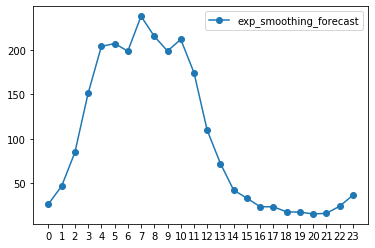

In [303]:
# show plot
# plot scores
plt.plot(hours, scores, marker='o', label=name)
plt.legend()
plt.show()

In [308]:
scores

[26.912773104108567,
 47.10444456124033,
 84.8716065148456,
 151.23429846402198,
 203.82239371507495,
 207.13063888928352,
 198.59294736608078,
 237.74516420511318,
 215.29044930356415,
 198.72661513027666,
 211.80507532970108,
 174.3808405529127,
 109.6804442295578,
 72.39076795824022,
 42.53782551912245,
 33.474568113189235,
 23.926280665066386,
 23.813926281486253,
 18.120676501149966,
 17.834272300604884,
 15.829272443667731,
 16.45744699284389,
 24.42185871025196,
 36.631830480076445]

5

28